In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import mplhep as hep
hep.style.use([hep.style.ATLAS])

- implement ATLAS selection 
        - done?
- implement own selection on balanced data
    - correct z0 to delta z0 and var3 to sigma_z0=sqrt(var3_1+var3_2)
        - done!
- make plot of two histograms (signal and background as a function of score)
    - done!
- make plot of signal vs background as a function of chosen score cutoff (ATLAS should be (1,1)?)
    - done?
- make selection for electron pairs require energy (momentum)>10GeV
    - done (9GeV for safety)

In [2]:
sample = pd.read_parquet('~/H_Zg/samples_processed/HZeeg_ggF_MC_reduced_Zmodel_eepairs_1Sep_extendedvariables80000_2labels.parquet')

In [3]:
print(sample.shape)
print(sample.columns)

(2336625, 65)
Index(['event_index', 'el_index', 'runNumber', 'eventNumber',
       'actualInteractionsPerCrossing', 'averageInteractionsPerCrossing',
       'm_ee', 'isZ', 'isZnew', 'el1_pt', 'el1_eta', 'el1_phi', 'el1_m',
       'el1_charge', 'el1_ptvarcone20', 'el1_topoetcone20', 'el1_topoetcone40',
       'el1_f1', 'el1_neflowisol20', 'el1_truthPdgId', 'el1_truthType',
       'el1_truthOrigin', 'el1_DFCommonElectronsECIDS',
       'el1_DFCommonElectronsECIDSResult', 'el1_DFCommonElectrons_pel',
       'el1_DFcommonElectrons_LHLoose', 'el1_GSFTrack_d0', 'el1_GSFTrack_z0',
       'el1_GSFTrack_theta', 'el1_GSFTrack_phi', 'el1_GSFTrack_qOverP',
       'el1_GSF_dR', 'el1_GSF_Track_Var0', 'el1_GSF_Track_Var1',
       'el1_GSF_Track_Var2', 'el1_GSF_Track_Var3', 'el1_GSF_Track_Var4',
       'el2_pt', 'el2_eta', 'el2_phi', 'el2_m', 'el2_charge',
       'el2_ptvarcone20', 'el2_topoetcone20', 'el2_topoetcone40', 'el2_f1',
       'el2_neflowisol20', 'el2_truthPdgId', 'el2_truthType',
       'e

In [4]:
dz = np.abs(sample['el1_GSFTrack_z0']-sample['el2_GSFTrack_z0'])
sigma_dz = np.sqrt(sample['el1_GSF_Track_Var3']+sample['el2_GSF_Track_Var3'])
sample['dz'] = dz
sample['sigma_dz'] = sigma_dz

In [5]:
ATLAS_label = sample['el1_DFcommonElectrons_LHLoose'] & sample['el2_DFcommonElectrons_LHLoose'] & (np.abs(sample['el1_eta']) < 2.7) & (np.abs(sample['el2_eta']) < 2.7) & (sample['el1_pt'] > 10000) & (sample['el2_pt'] > 10000)
## append ATLAS_label to sample
sample['ATLAS_label'] = ATLAS_label

In [6]:
drop_list = ['isZ', 'isZnew', 'm_ee', 'event_index', 'el_index', 'runNumber', 'eventNumber', 'el1_pt', 'el2_pt'
             , 'el1_truthPdgId', 'el2_truthPdgId', 'el1_truthOrigin', 'el2_truthOrigin', 'el1_truthType', 'el2_truthType',
             'el1_GSFTrack_qOverP', 'el2_GSFTrack_qOverP', 'el1_GSF_Track_Var0', 'el2_GSF_Track_Var0', 'el1_GSF_Track_Var1', 'el2_GSF_Track_Var1',
             'el1_GSF_Track_Var2', 'el2_GSF_Track_Var2', 'el1_GSF_Track_Var4', 'el2_GSF_Track_Var4',
             'el1_GSFTrack_theta', 'el2_GSFTrack_theta', 'el1_GSFTrack_phi', 'el2_GSFTrack_phi', 'el1_phi', 'el2_phi'
             , 'el1_DFcommonElectrons_LHLoose', 'el2_DFcommonElectrons_LHLoose',
             'el1_GSFTrack_z0', 'el2_GSFTrack_z0', 'el1_GSF_Track_Var3', 'el2_GSF_Track_Var3', 'ATLAS_label', 'el1_GSF_dR', 'el2_GSF_dR',
             'el1_GSFTrack_d0', 'el1_GSFTrack_d0']

In [7]:
mask_GEV = (sample['el1_pt'] > 9000) & (sample['el2_pt'] > 9000)
# ATLAS_label = ATLAS_label[mask_GEV]
sample = sample[mask_GEV]

In [8]:
isZ = sample[sample['isZnew'] == 1]
isNotZ = sample[sample['isZnew'] == 0]
isNotZ_sampled = isNotZ.sample(frac=0.2, random_state=42) 
small_sample = pd.concat([isZ, isNotZ_sampled])

print(f'full sample size:{len(sample)}, number of Z:{len(isZ)}, number of not Z:{len(isNotZ)}')
print(f'small sample size:{len(small_sample)}, number of Z:{len(isZ)}, number of not Z:{len(isNotZ_sampled)}')


full sample size:111542, number of Z:17746, number of not Z:93796
small sample size:36505, number of Z:17746, number of not Z:18759


no


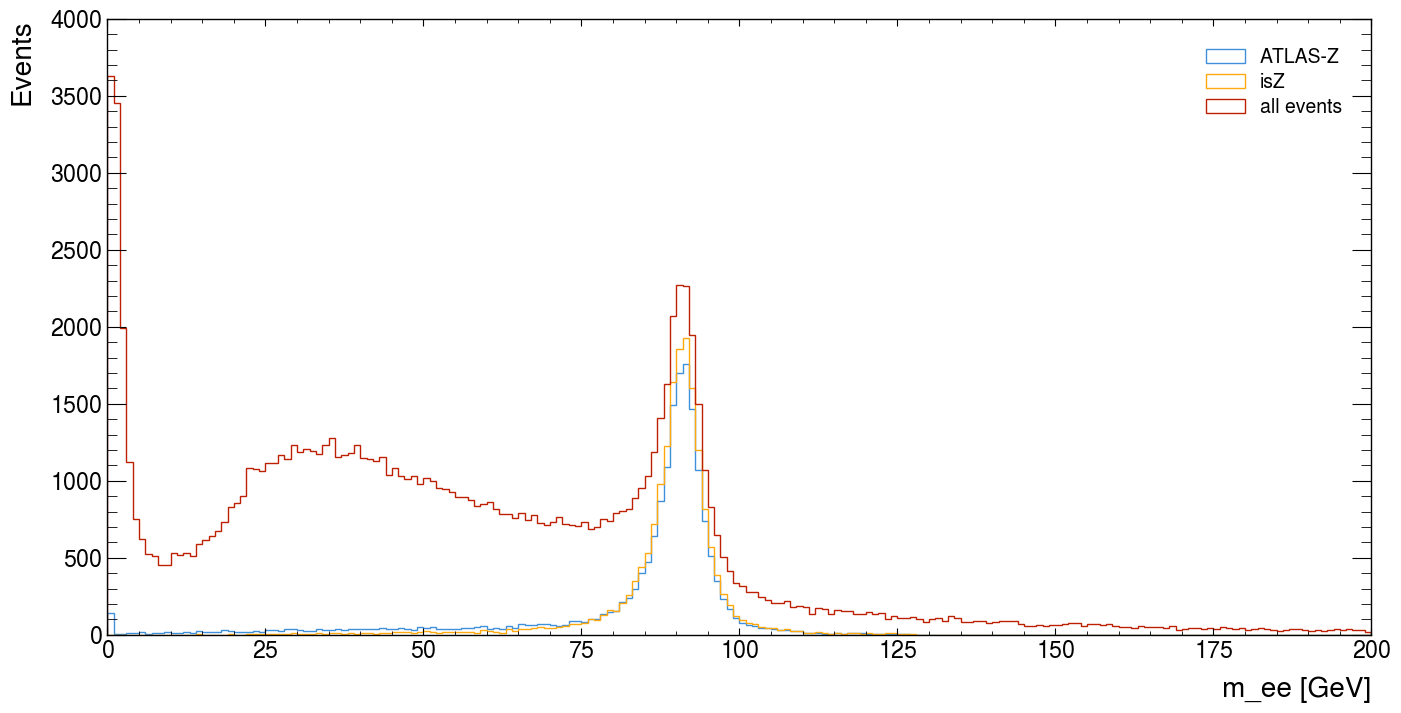

In [9]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(sample['m_ee'][ATLAS_label==1], bins=200, range=(0, 200), histtype='step', label='ATLAS-Z')
ax.hist(sample['m_ee'][sample['isZnew']==1], bins=200, range=(0, 200), histtype='step', label='isZ')
ax.hist(sample['m_ee'], bins=200, range=(0, 200), histtype='step', label='all events')
ax.set_xlabel('m_ee [GeV]')
ax.set_ylabel('Events')
ax.legend()
# ax.set_title('ATLAS label')
print('no')

In [10]:
input_data = small_sample
truth_data = small_sample['isZnew']

In [11]:
import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

r = np.random
r.seed(12)

X_train, X_test, y_train, y_test = train_test_split(input_data, truth_data, test_size=0.25, random_state=12)
X_train = X_train.drop(columns=drop_list)
full_val_data = X_test
full_val_label = y_test
X_test = X_test.drop(columns=drop_list)
print(f'total number of pairs in training sample: {len(X_train)}, true Z pairs: {len(X_train[y_train==1])}, true not Z pairs: {len(X_train[y_train==0])}')
print(f'total number of pairs in testing sample: {len(X_test)}, true Z pairs: {len(X_test[y_test==1])}, true not Z pairs: {len(X_test[y_test==0])}')


/groups/hep/kinch/python/initenv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


total number of pairs in training sample: 27378, true Z pairs: 13302, true not Z pairs: 14076
total number of pairs in testing sample: 9127, true Z pairs: 4444, true not Z pairs: 4683


In [12]:
def objective(trial):
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'boosting_type': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 0, 100),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1,log=True),
        'drop_rate': trial.suggest_float('drop_rate', 0.005, 0.4),
        'verbose': 0
    }

    dtrain = lgb.Dataset(X_train, label=y_train)
    gbm = lgb.train(param, dtrain)
    preds = gbm.predict(X_test)
    auc = roc_auc_score(y_test, preds)
    return auc

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)


[I 2024-09-03 16:50:56,062] A new study created in memory with name: no-name-e081208e-cc64-44a1-88a9-33c47e395e79


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002499 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2024-09-03 16:50:56,827] Trial 0 finished with value: 0.9827857065014637 and parameters: {'max_depth': 24, 'num_leaves': 52, 'learning_rate': 0.0006042986263514832, 'drop_rate': 0.21837794169207067}. Best is trial 0 with value: 0.9827857065014637.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001677 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:50:59,004] Trial 1 finished with value: 0.9824289283508747 and parameters: {'max_depth': 47, 'num_leaves': 178, 'learning_rate': 0.000231909335657367, 'drop_rate': 0.3229324540985916}. Best is trial 0 with value: 0.9827857065014637.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002211 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:00,627] Trial 2 finished with value: 0.9882137797379994 and parameters: {'max_depth': 64, 'num_leaves': 115, 'learning_rate': 0.009644163889404941, 'drop_rate': 0.28225103748801533}. Best is trial 2 with value: 0.9882137797379994.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002070 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:01,112] Trial 3 finished with value: 0.9891782579923593 and parameters: {'max_depth': 27, 'num_leaves': 29, 'learning_rate': 0.04141719045840936, 'drop_rate': 0.3486032836249689}. Best is trial 3 with value: 0.9891782579923593.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002468 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:04,000] Trial 4 finished with value: 0.989801406469923 and parameters: {'max_depth': 56, 'num_leaves': 229, 'learning_rate': 0.05182902451635113, 'drop_rate': 0.2940804400821163}. Best is trial 4 with value: 0.989801406469923.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002042 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:06,470] Trial 5 finished with value: 0.9819505573235094 and parameters: {'max_depth': 21, 'num_leaves': 198, 'learning_rate': 0.0001556336818752514, 'drop_rate': 0.35628490766012527}. Best is trial 4 with value: 0.989801406469923.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002184 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:09,643] Trial 6 finished with value: 0.9859932261643847 and parameters: {'max_depth': 55, 'num_leaves': 216, 'learning_rate': 0.003669223440382774, 'drop_rate': 0.27070945486413467}. Best is trial 4 with value: 0.989801406469923.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002656 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2024-09-03 16:51:11,793] Trial 7 finished with value: 0.9833046565386839 and parameters: {'max_depth': 24, 'num_leaves': 142, 'learning_rate': 0.00013958414243817155, 'drop_rate': 0.34263032702991825}. Best is trial 4 with value: 0.989801406469923.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002188 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:14,250] Trial 8 finished with value: 0.9847426767020071 and parameters: {'max_depth': 77, 'num_leaves': 164, 'learning_rate': 0.0011433617502132859, 'drop_rate': 0.2743407813095412}. Best is trial 4 with value: 0.989801406469923.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001856 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:16,074] Trial 9 finished with value: 0.9842964757718564 and parameters: {'max_depth': 35, 'num_leaves': 113, 'learning_rate': 0.00033125999127529154, 'drop_rate': 0.13475493801796462}. Best is trial 4 with value: 0.989801406469923.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002398 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:19,642] Trial 10 finished with value: 0.9904909132809502 and parameters: {'max_depth': 95, 'num_leaves': 229, 'learning_rate': 0.08137282594988855, 'drop_rate': 0.021963157693955765}. Best is trial 10 with value: 0.9904909132809502.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002199 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:23,548] Trial 11 finished with value: 0.9904271016467437 and parameters: {'max_depth': 99, 'num_leaves': 238, 'learning_rate': 0.09963735369115659, 'drop_rate': 0.008991593214665732}. Best is trial 10 with value: 0.9904909132809502.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002674 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:27,796] Trial 12 finished with value: 0.9904737590991642 and parameters: {'max_depth': 96, 'num_leaves': 256, 'learning_rate': 0.08901300524968024, 'drop_rate': 0.009590707623024683}. Best is trial 10 with value: 0.9904909132809502.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003093 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:31,079] Trial 13 finished with value: 0.9889828108371373 and parameters: {'max_depth': 98, 'num_leaves': 235, 'learning_rate': 0.021105898044241407, 'drop_rate': 0.0078120350998954965}. Best is trial 10 with value: 0.9904909132809502.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001787 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:35,304] Trial 14 finished with value: 0.9906783599564313 and parameters: {'max_depth': 0, 'num_leaves': 256, 'learning_rate': 0.09808013271667487, 'drop_rate': 0.07279042974327521}. Best is trial 14 with value: 0.9906783599564313.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002898 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:38,045] Trial 15 finished with value: 0.9891009680724638 and parameters: {'max_depth': 0, 'num_leaves': 194, 'learning_rate': 0.02243268896205982, 'drop_rate': 0.07526774580157469}. Best is trial 14 with value: 0.9906783599564313.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003215 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:41,204] Trial 16 finished with value: 0.9868507911008909 and parameters: {'max_depth': 0, 'num_leaves': 251, 'learning_rate': 0.005295323978276913, 'drop_rate': 0.09619176545801542}. Best is trial 14 with value: 0.9906783599564313.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001937 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:42,531] Trial 17 finished with value: 0.9881669300818615 and parameters: {'max_depth': 75, 'num_leaves': 85, 'learning_rate': 0.013535778543651266, 'drop_rate': 0.14574554030758785}. Best is trial 14 with value: 0.9906783599564313.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003656 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:45,012] Trial 18 finished with value: 0.9896831771582026 and parameters: {'max_depth': 83, 'num_leaves': 210, 'learning_rate': 0.041488891545560756, 'drop_rate': 0.058707973261406116}. Best is trial 14 with value: 0.9906783599564313.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002399 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:46,847] Trial 19 finished with value: 0.9883575000677517 and parameters: {'max_depth': 37, 'num_leaves': 158, 'learning_rate': 0.007495454317710905, 'drop_rate': 0.39949919204615625}. Best is trial 14 with value: 0.9906783599564313.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002178 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:47,880] Trial 20 finished with value: 0.9852123505111562 and parameters: {'max_depth': 11, 'num_leaves': 78, 'learning_rate': 0.0016481485694826957, 'drop_rate': 0.05030214380183755}. Best is trial 14 with value: 0.9906783599564313.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031328 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:51,550] Trial 21 finished with value: 0.9903404658210856 and parameters: {'max_depth': 87, 'num_leaves': 249, 'learning_rate': 0.08430575216020886, 'drop_rate': 0.030466611453471577}. Best is trial 14 with value: 0.9906783599564313.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002107 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:54,533] Trial 22 finished with value: 0.9903545447433917 and parameters: {'max_depth': 92, 'num_leaves': 217, 'learning_rate': 0.08988988434081714, 'drop_rate': 0.09556748845715629}. Best is trial 14 with value: 0.9906783599564313.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001810 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:51:57,546] Trial 23 finished with value: 0.9893733687910751 and parameters: {'max_depth': 67, 'num_leaves': 255, 'learning_rate': 0.02979798122722187, 'drop_rate': 0.02718252822599898}. Best is trial 14 with value: 0.9906783599564313.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001840 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:00,228] Trial 24 finished with value: 0.990282804705839 and parameters: {'max_depth': 90, 'num_leaves': 187, 'learning_rate': 0.05868656470733234, 'drop_rate': 0.006506549693348462}. Best is trial 14 with value: 0.9906783599564313.
[I 2024-09-03 16:52:00,449] Trial 25 finished with value: 0.980094686278365 and parameters: {'max_depth': 78, 'num_leaves': 4, 'learning_rate': 0.016157309424156902, 'drop_rate': 0.048370274265755166}. Best is trial 14 with value: 0.9906783599564313.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003408 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2024-09-03 16:52:03,658] Trial 26 finished with value: 0.9893889132667271 and parameters: {'max_depth': 68, 'num_leaves': 227, 'learning_rate': 0.030664419884483644, 'drop_rate': 0.08130830603413161}. Best is trial 14 with value: 0.9906783599564313.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002081 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:06,404] Trial 27 finished with value: 0.9901072025844482 and parameters: {'max_depth': 44, 'num_leaves': 211, 'learning_rate': 0.06078877000836078, 'drop_rate': 0.11912820803621108}. Best is trial 14 with value: 0.9906783599564313.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001814 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:09,699] Trial 28 finished with value: 0.9891077192280405 and parameters: {'max_depth': 13, 'num_leaves': 256, 'learning_rate': 0.0342976490427959, 'drop_rate': 0.049798352854447045}. Best is trial 14 with value: 0.9906783599564313.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002868 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:12,445] Trial 29 finished with value: 0.9908370241252185 and parameters: {'max_depth': 100, 'num_leaves': 174, 'learning_rate': 0.09873401549924722, 'drop_rate': 0.18620336065515034}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001948 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:15,182] Trial 30 finished with value: 0.9897995324836775 and parameters: {'max_depth': 82, 'num_leaves': 170, 'learning_rate': 0.049278489790389, 'drop_rate': 0.17884713320018275}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004059 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:19,899] Trial 31 finished with value: 0.9905789425835602 and parameters: {'max_depth': 100, 'num_leaves': 237, 'learning_rate': 0.09515206127572685, 'drop_rate': 0.22339700169379673}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001885 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:22,479] Trial 32 finished with value: 0.9902561844909666 and parameters: {'max_depth': 93, 'num_leaves': 145, 'learning_rate': 0.06253584084176783, 'drop_rate': 0.21017770926149515}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002138 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:25,252] Trial 33 finished with value: 0.9892502142590942 and parameters: {'max_depth': 100, 'num_leaves': 184, 'learning_rate': 0.026420456855747135, 'drop_rate': 0.24817001248914047}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003110 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:29,094] Trial 34 finished with value: 0.9904178758683044 and parameters: {'max_depth': 87, 'num_leaves': 239, 'learning_rate': 0.09493087109921204, 'drop_rate': 0.18422716937289513}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2024-09-03 16:52:32,542] Trial 35 finished with value: 0.9897887690754982 and parameters: {'max_depth': 72, 'num_leaves': 224, 'learning_rate': 0.041392688940585926, 'drop_rate': 0.17623146832374803}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003808 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2024-09-03 16:52:36,333] Trial 36 finished with value: 0.9900325314402036 and parameters: {'max_depth': 84, 'num_leaves': 201, 'learning_rate': 0.059387407729040734, 'drop_rate': 0.22858527870979392}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001795 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:38,450] Trial 37 finished with value: 0.9886365077891517 and parameters: {'max_depth': 54, 'num_leaves': 206, 'learning_rate': 0.013389714213758244, 'drop_rate': 0.1587243448258997}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002152 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:39,815] Trial 38 finished with value: 0.9894038571057618 and parameters: {'max_depth': 59, 'num_leaves': 114, 'learning_rate': 0.040340810251532515, 'drop_rate': 0.22278181197873265}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001803 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:41,967] Trial 39 finished with value: 0.9902777593582549 and parameters: {'max_depth': 45, 'num_leaves': 174, 'learning_rate': 0.06738318040147372, 'drop_rate': 0.11542893753258895}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001800 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:43,564] Trial 40 finished with value: 0.9896174675122863 and parameters: {'max_depth': 94, 'num_leaves': 129, 'learning_rate': 0.04368456916850109, 'drop_rate': 0.24801532018488542}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001891 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:46,235] Trial 41 finished with value: 0.9905076350043717 and parameters: {'max_depth': 96, 'num_leaves': 231, 'learning_rate': 0.09973728834593423, 'drop_rate': 0.03513892502271593}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001823 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:49,031] Trial 42 finished with value: 0.9900679209496861 and parameters: {'max_depth': 100, 'num_leaves': 241, 'learning_rate': 0.07188329352573676, 'drop_rate': 0.19456581254292035}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2024-09-03 16:52:51,607] Trial 43 finished with value: 0.9903146624720126 and parameters: {'max_depth': 89, 'num_leaves': 227, 'learning_rate': 0.09366650230326429, 'drop_rate': 0.029501636460793568}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001882 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:54,116] Trial 44 finished with value: 0.9897988117197369 and parameters: {'max_depth': 95, 'num_leaves': 222, 'learning_rate': 0.051606231281488925, 'drop_rate': 0.06888263151150315}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001822 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:56,740] Trial 45 finished with value: 0.9901189510366796 and parameters: {'max_depth': 30, 'num_leaves': 240, 'learning_rate': 0.07118708842238622, 'drop_rate': 0.2934033063421856}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002289 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:52:59,206] Trial 46 finished with value: 0.9907345314928674 and parameters: {'max_depth': 80, 'num_leaves': 191, 'learning_rate': 0.09948079764380513, 'drop_rate': 0.1627153965178272}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001852 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:00,987] Trial 47 finished with value: 0.9896602088139627 and parameters: {'max_depth': 82, 'num_leaves': 154, 'learning_rate': 0.03314888938407705, 'drop_rate': 0.1597131745866289}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:02,946] Trial 48 finished with value: 0.9906948414252059 and parameters: {'max_depth': 79, 'num_leaves': 190, 'learning_rate': 0.09877760799784166, 'drop_rate': 0.20095868783207496}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001750 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:04,965] Trial 49 finished with value: 0.9898625272520846 and parameters: {'max_depth': 72, 'num_leaves': 188, 'learning_rate': 0.04972375875343922, 'drop_rate': 0.2198069929356592}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:06,290] Trial 50 finished with value: 0.9890680772113086 and parameters: {'max_depth': 63, 'num_leaves': 129, 'learning_rate': 0.02110723205171621, 'drop_rate': 0.198011938466159}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002026 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:08,374] Trial 51 finished with value: 0.9902705036679197 and parameters: {'max_depth': 79, 'num_leaves': 198, 'learning_rate': 0.07519129848960539, 'drop_rate': 0.20239382688242424}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001792 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:10,681] Trial 52 finished with value: 0.9905688518883919 and parameters: {'max_depth': 88, 'num_leaves': 215, 'learning_rate': 0.0928794370589885, 'drop_rate': 0.1618333708676176}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003125 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:12,657] Trial 53 finished with value: 0.9902871773404118 and parameters: {'max_depth': 88, 'num_leaves': 182, 'learning_rate': 0.06843586624680828, 'drop_rate': 0.1655285679033585}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002064 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:14,501] Trial 54 finished with value: 0.9907835434408271 and parameters: {'max_depth': 17, 'num_leaves': 167, 'learning_rate': 0.09694288649417153, 'drop_rate': 0.18479830376295805}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2024-09-03 16:53:14,916] Trial 55 finished with value: 0.9891842163076013 and parameters: {'max_depth': 5, 'num_leaves': 169, 'learning_rate': 0.04973342753932444, 'drop_rate': 0.12923015450994696}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-03 16:53:15,997] Trial 56 finished with value: 0.9905593858553056 and parameters: {'max_depth': 11, 'num_leaves': 99, 'learning_rate': 0.07186455400022077, 'drop_rate': 0.14662233074798336}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002174 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:17,688] Trial 57 finished with value: 0.9895651640756643 and parameters: {'max_depth': 23, 'num_leaves': 164, 'learning_rate': 0.03595086905573004, 'drop_rate': 0.19498392496997496}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003517 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:19,175] Trial 58 finished with value: 0.9901964331602923 and parameters: {'max_depth': 16, 'num_leaves': 141, 'learning_rate': 0.05410568006664357, 'drop_rate': 0.2359715611494042}. Best is trial 29 with value: 0.9908370241252185.
[I 2024-09-03 16:53:19,336] Trial 59 finished with value: 0.9889543887124138 and parameters: {'max_depth': 2, 'num_leaves': 151, 'learning_rate': 0.09931290766228805, 'drop_rate': 0.20449411863245767}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001889 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001847 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:21,370] Trial 60 finished with value: 0.9901895378519274 and parameters: {'max_depth': 40, 'num_leaves': 196, 'learning_rate': 0.07188579218652587, 'drop_rate': 0.1851296334157183}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001855 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:24,083] Trial 61 finished with value: 0.9905936942188774 and parameters: {'max_depth': 31, 'num_leaves': 211, 'learning_rate': 0.08328361731515348, 'drop_rate': 0.21318020568416352}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001790 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:26,629] Trial 62 finished with value: 0.9905254618991688 and parameters: {'max_depth': 28, 'num_leaves': 206, 'learning_rate': 0.07894380196576155, 'drop_rate': 0.2134926250980215}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2024-09-03 16:53:27,462] Trial 63 finished with value: 0.9895893577186032 and parameters: {'max_depth': 7, 'num_leaves': 191, 'learning_rate': 0.05543090185206389, 'drop_rate': 0.17377381927826102}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-03 16:53:30,500] Trial 64 finished with value: 0.9903562265259198 and parameters: {'max_depth': 31, 'num_leaves': 244, 'learning_rate': 0.07781086570680872, 'drop_rate': 0.21239521661364427}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002076 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:32,871] Trial 65 finished with value: 0.990627089614791 and parameters: {'max_depth': 23, 'num_leaves': 175, 'learning_rate': 0.09861478577515806, 'drop_rate': 0.1899153906479062}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002096 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:35,072] Trial 66 finished with value: 0.9893028300267566 and parameters: {'max_depth': 17, 'num_leaves': 178, 'learning_rate': 0.04102329225221314, 'drop_rate': 0.1455714016337219}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002001 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:37,238] Trial 67 finished with value: 0.9902517638054645 and parameters: {'max_depth': 51, 'num_leaves': 164, 'learning_rate': 0.06005455612210287, 'drop_rate': 0.18763485222558868}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[I 2024-09-03 16:53:39,873] Trial 68 finished with value: 0.98921071639515 and parameters: {'max_depth': 19, 'num_leaves': 176, 'learning_rate': 0.026489928888530925, 'drop_rate': 0.1742497559181415}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001895 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:42,046] Trial 69 finished with value: 0.990190258615868 and parameters: {'max_depth': 34, 'num_leaves': 158, 'learning_rate': 0.08245592848727316, 'drop_rate': 0.19497483629160378}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003081 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:44,721] Trial 70 finished with value: 0.9897598664414806 and parameters: {'max_depth': 24, 'num_leaves': 202, 'learning_rate': 0.04748706397082659, 'drop_rate': 0.23764473913510498}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002058 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:47,505] Trial 71 finished with value: 0.9906061394095846 and parameters: {'max_depth': 13, 'num_leaves': 220, 'learning_rate': 0.09806809712571662, 'drop_rate': 0.20814763502259476}. Best is trial 29 with value: 0.9908370241252185.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2024-09-03 16:53:48,113] Trial 72 finished with value: 0.991016926804788 and parameters: {'max_depth': 6, 'num_leaves': 216, 'learning_rate': 0.09977738301688865, 'drop_rate': 0.20712603142212965}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-03 16:53:49,092] Trial 73 finished with value: 0.9901220262961595 and parameters: {'max_depth': 10, 'num_leaves': 57, 'learning_rate': 0.06379323212169358, 'drop_rate': 0.18687612574552467}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001825 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2024-09-03 16:53:49,719] Trial 74 finished with value: 0.9906341050504793 and parameters: {'max_depth': 6, 'num_leaves': 191, 'learning_rate': 0.09581881791716056, 'drop_rate': 0.1707345050216544}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-03 16:53:50,008] Trial 75 finished with value: 0.989043931619299 and parameters: {'max_depth': 4, 'num_leaves': 193, 'learning_rate': 0.05803105979899725, 'drop_rate': 0.14517277949331953}. Best is trial 72 with value: 0.991016926804788.
[I 2024-09-03 16:53:50,146] Trial 76 finished with value: 0.9865483105004927 and parameters: {'max_depth': 1, 'num_leaves': 183, 'learning_rate': 0.0775074600107616, 'drop_rate': 0.16838792678767686}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-09-03 16:53:50,749] Trial 77 finished with value: 0.9889936943726404 and parameters: {'max_depth': 6, 'num_leaves': 136, 'learning_rate': 0.037542299982591815, 'drop_rate': 0.15488396817476346}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-03 16:53:53,003] Trial 78 finished with value: 0.9892895679702499 and parameters: {'max_depth': 9, 'num_leaves': 171, 'learning_rate': 0.04409493894715802, 'drop_rate': 0.1764293599811389}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001831 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:54,960] Trial 79 finished with value: 0.990047499304703 and parameters: {'max_depth': 15, 'num_leaves': 165, 'learning_rate': 0.06395837352980588, 'drop_rate': 0.13307023693216072}. Best is trial 72 with value: 0.991016926804788.
[I 2024-09-03 16:53:55,204] Trial 80 finished with value: 0.9891591577479337 and parameters: {'max_depth': 3, 'num_leaves': 188, 'learning_rate': 0.08440260474616394, 'drop_rate': 0.18006625062962572}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001926 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:53:57,978] Trial 81 finished with value: 0.9905349279322552 and parameters: {'max_depth': 20, 'num_leaves': 217, 'learning_rate': 0.08895512523458517, 'drop_rate': 0.2076774190684458}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2024-09-03 16:53:59,001] Trial 82 finished with value: 0.9908199179943619 and parameters: {'max_depth': 7, 'num_leaves': 206, 'learning_rate': 0.09847822526028749, 'drop_rate': 0.1909610193090835}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-03 16:53:59,603] Trial 83 finished with value: 0.990355746016626 and parameters: {'max_depth': 6, 'num_leaves': 205, 'learning_rate': 0.09960607986412885, 'drop_rate': 0.19089741381472175}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-03 16:54:02,088] Trial 84 finished with value: 0.99035468889618 and parameters: {'max_depth': 0, 'num_leaves': 180, 'learning_rate': 0.06635037257821035, 'drop_rate': 0.16831578659350066}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2024-09-03 16:54:03,840] Trial 85 finished with value: 0.9895652361520584 and parameters: {'max_depth': 9, 'num_leaves': 196, 'learning_rate': 0.05346414637436761, 'drop_rate': 0.20080007914799744}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001951 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2024-09-03 16:54:06,673] Trial 86 finished with value: 0.9903772728329847 and parameters: {'max_depth': 12, 'num_leaves': 231, 'learning_rate': 0.07671359943129864, 'drop_rate': 0.18834277463686835}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002025 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2024-09-03 16:54:08,283] Trial 87 finished with value: 0.9906751885950927 and parameters: {'max_depth': 8, 'num_leaves': 188, 'learning_rate': 0.09911554110706323, 'drop_rate': 0.15431057085152164}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001909 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:54:11,071] Trial 88 finished with value: 0.9899142060266245 and parameters: {'max_depth': 58, 'num_leaves': 208, 'learning_rate': 0.04621319229070689, 'drop_rate': 0.15506210044752003}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2024-09-03 16:54:12,573] Trial 89 finished with value: 0.9896394267870092 and parameters: {'max_depth': 8, 'num_leaves': 186, 'learning_rate': 0.06408768401858654, 'drop_rate': 0.16604500007069795}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-03 16:54:16,356] Trial 90 finished with value: 0.9898739153223457 and parameters: {'max_depth': 14, 'num_leaves': 246, 'learning_rate': 0.07946990381228199, 'drop_rate': 0.22337254848921806}. Best is trial 72 with value: 0.991016926804788.
[I 2024-09-03 16:54:16,581] Trial 91 finished with value: 0.9893046079111435 and parameters: {'max_depth': 3, 'num_leaves': 174, 'learning_rate': 0.09881701987742433, 'drop_rate': 0.1805143741832846}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2024-09-03 16:54:16,992] Trial 92 finished with value: 0.9901705096838961 and parameters: {'max_depth': 5, 'num_leaves': 197, 'learning_rate': 0.08280199029739012, 'drop_rate': 0.17189416671623306}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2024-09-03 16:54:19,974] Trial 93 finished with value: 0.989784804873825 and parameters: {'max_depth': 69, 'num_leaves': 212, 'learning_rate': 0.05674412363451919, 'drop_rate': 0.1957764511622823}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001876 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:54:22,813] Trial 94 finished with value: 0.9905075148770482 and parameters: {'max_depth': 17, 'num_leaves': 192, 'learning_rate': 0.06976651122709183, 'drop_rate': 0.11211234769160168}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002175 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:54:25,543] Trial 95 finished with value: 0.9908992981296848 and parameters: {'max_depth': 62, 'num_leaves': 179, 'learning_rate': 0.08927023281262161, 'drop_rate': 0.15255991190260465}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001958 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:54:27,619] Trial 96 finished with value: 0.9903499799051014 and parameters: {'max_depth': 80, 'num_leaves': 158, 'learning_rate': 0.08319081815744339, 'drop_rate': 0.15429226626234824}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002089 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:54:29,887] Trial 97 finished with value: 0.9901129686959728 and parameters: {'max_depth': 64, 'num_leaves': 147, 'learning_rate': 0.06774892858949055, 'drop_rate': 0.14666254892765102}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002080 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:54:32,537] Trial 98 finished with value: 0.9899240084162164 and parameters: {'max_depth': 76, 'num_leaves': 182, 'learning_rate': 0.05291674180163556, 'drop_rate': 0.13728843134419907}. Best is trial 72 with value: 0.991016926804788.


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_col_wise=true` to remove the overhead.


[I 2024-09-03 16:54:34,928] Trial 99 finished with value: 0.9903561784749904 and parameters: {'max_depth': 74, 'num_leaves': 166, 'learning_rate': 0.08572861290616245, 'drop_rate': 0.20406791342986494}. Best is trial 72 with value: 0.991016926804788.


Number of finished trials: 100
Best trial: {'max_depth': 6, 'num_leaves': 216, 'learning_rate': 0.09977738301688865, 'drop_rate': 0.20712603142212965}


In [13]:
print('Best value:', study.best_value)
print('Best parameters:', study.best_params)

Best value: 0.991016926804788
Best parameters: {'max_depth': 6, 'num_leaves': 216, 'learning_rate': 0.09977738301688865, 'drop_rate': 0.20712603142212965}


In [14]:
model = lgb.LGBMClassifier(**study.best_params)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 13302, number of negative: 14076
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4987
[LightGBM] [Info] Number of data points in the train set: 27378, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.485865 -> initscore=-0.056557
[LightGBM] [Info] Start training from score -0.056557
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

LGBMClassifier(drop_rate=0.20712603142212965, learning_rate=0.09977738301688865,
               max_depth=6, num_leaves=216)

Text(0.5, 1.0, 'Receiver operating characteristic')

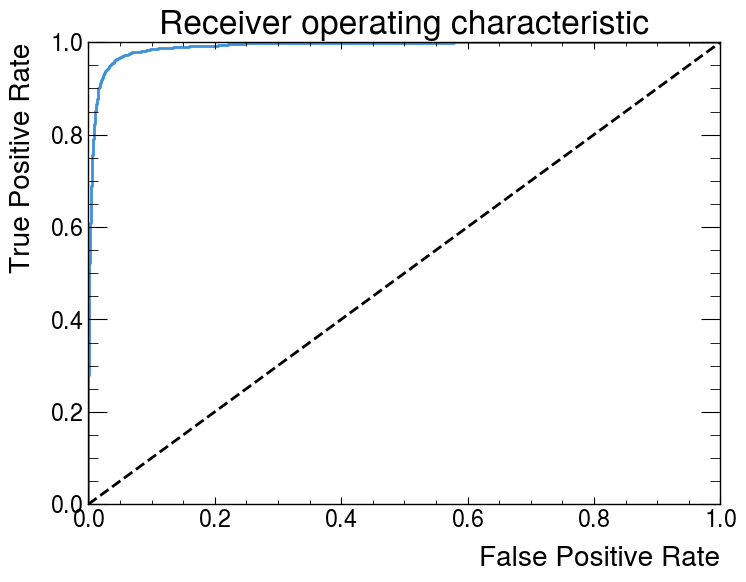

In [15]:
# roc curve

from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:0.2e})')
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Luck')
ax.set_xlim([0, 1.0])
ax.set_ylim([0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic')


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

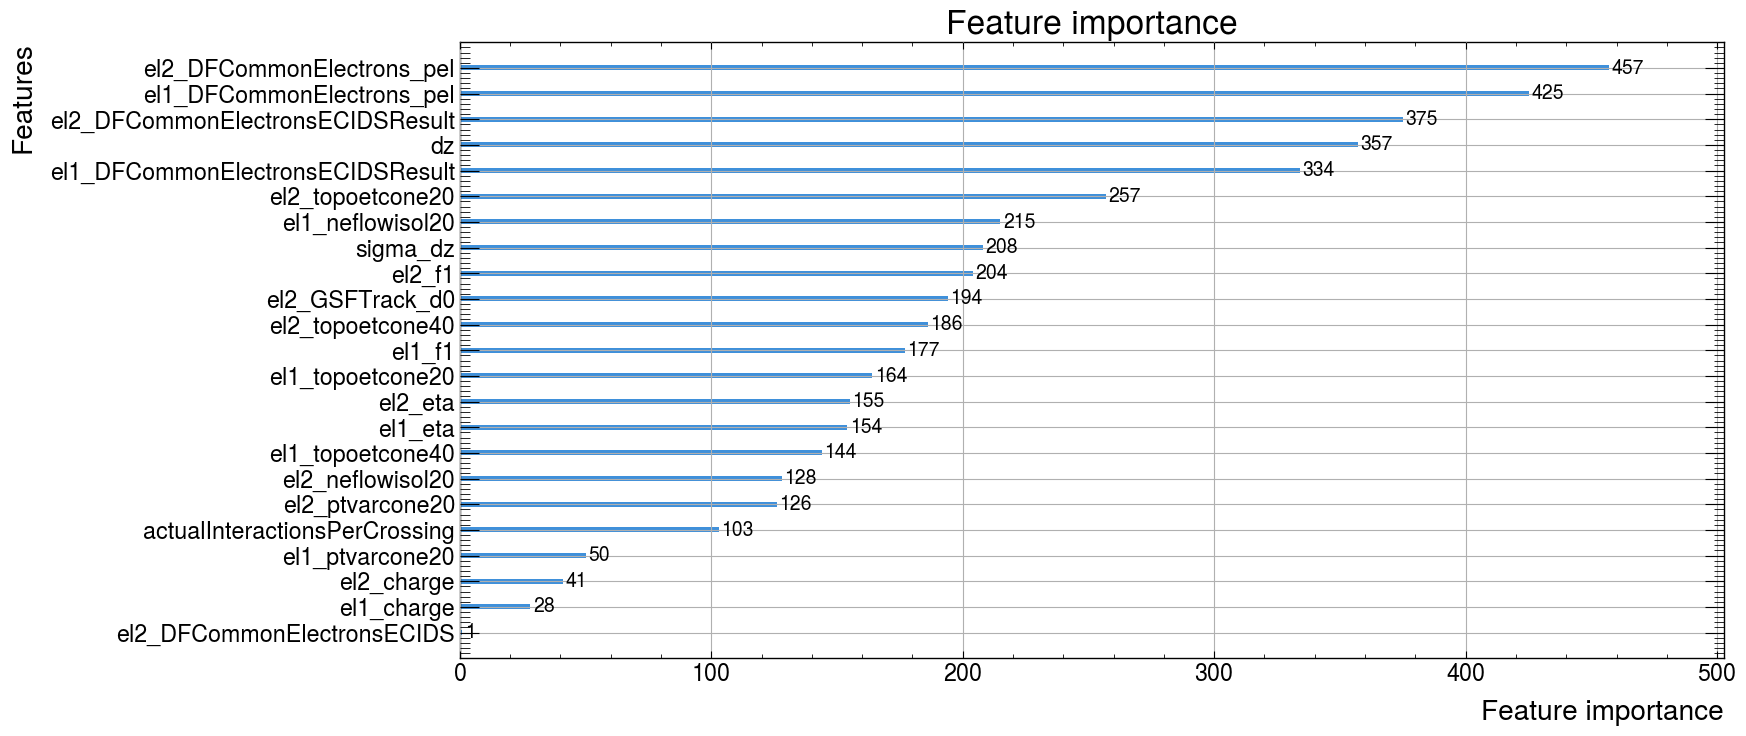

In [16]:
# feature importance
fig, ax = plt.subplots(figsize=(16, 8))
lgb.plot_importance(model, ax=ax)

In [17]:
scores = model.predict_proba(X_test)[:,1]
model_prediction = model.predict(X_test)

no


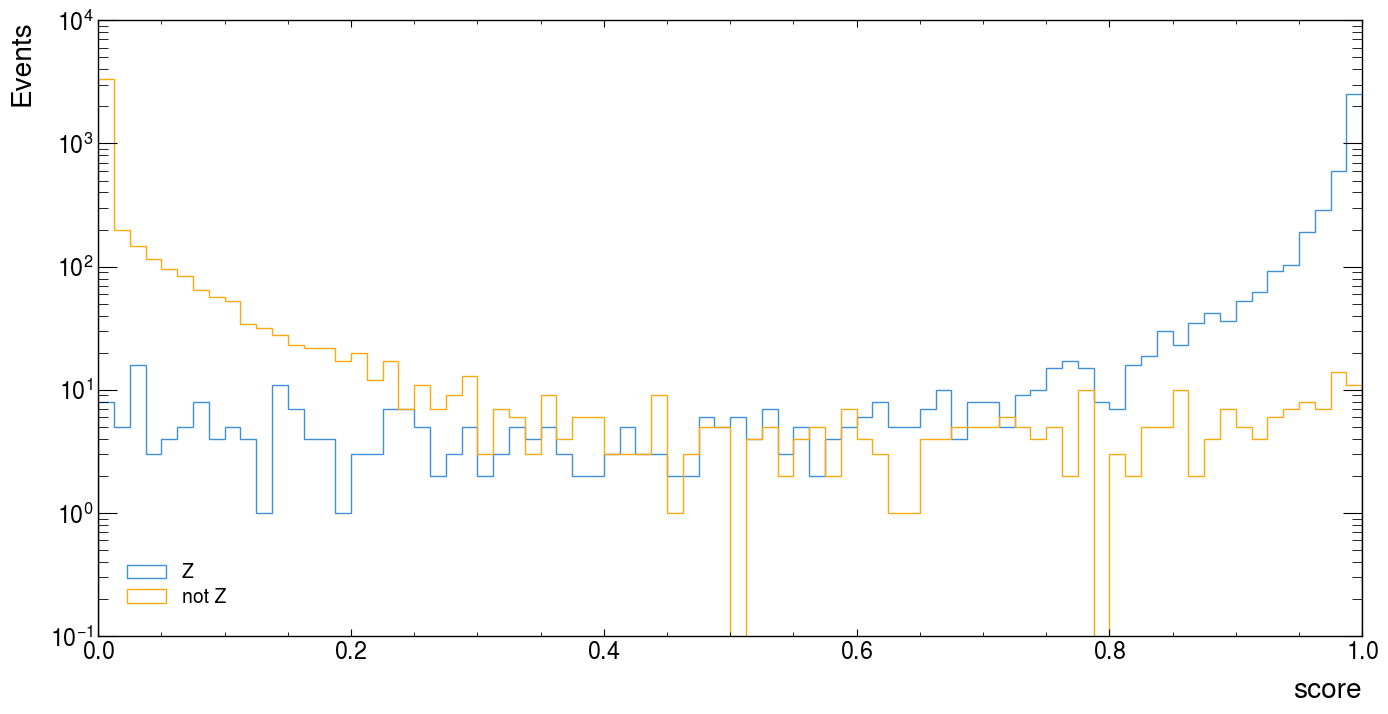

In [18]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.hist(scores[full_val_label==1], bins=80, range=(0, 1), histtype='step', label='Z')
ax.hist(scores[full_val_label==0], bins=80, range=(0, 1), histtype='step', label='not Z')
ax.set_xlabel('score')
ax.set_ylabel('Events')
ax.set_yscale('log')
ax.legend()

print('no')

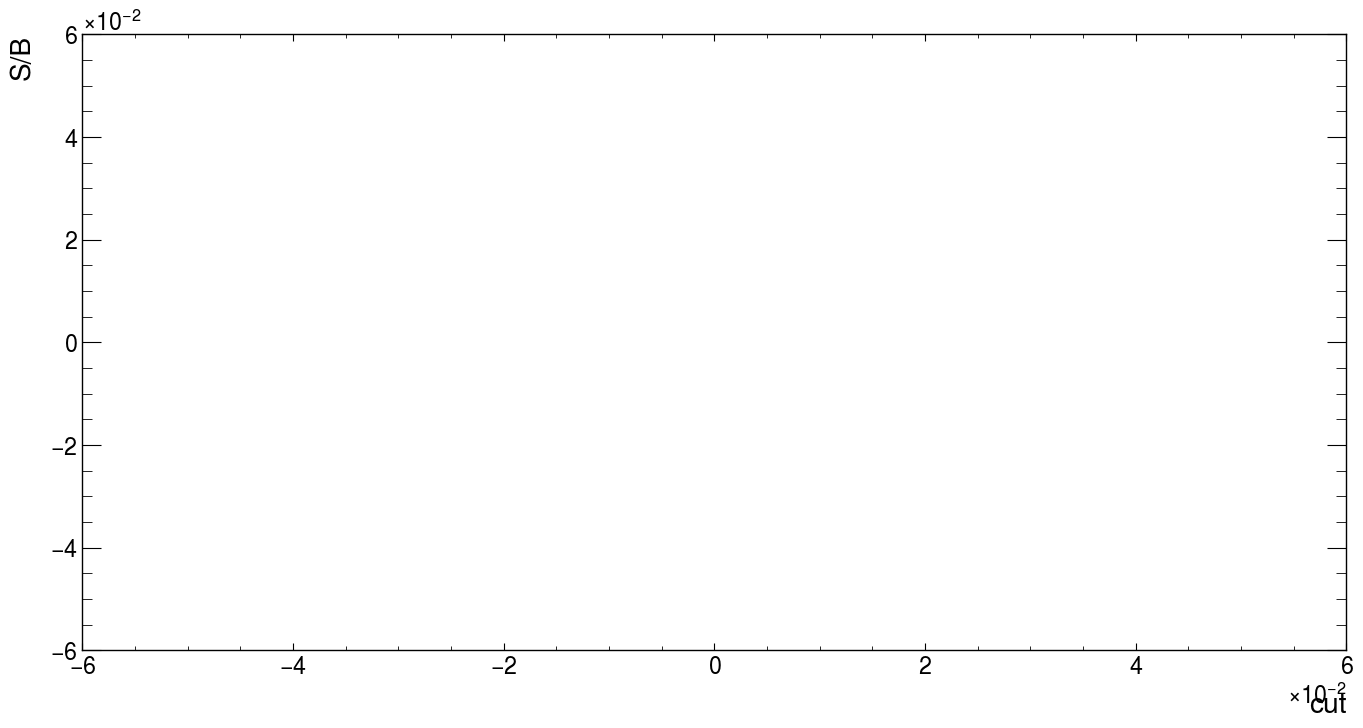

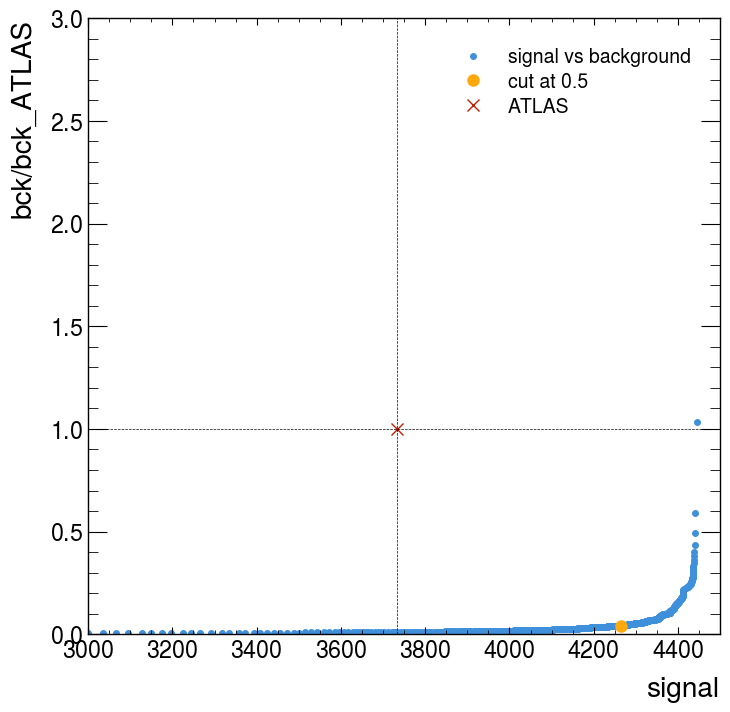

In [26]:
N = 10000
p = np.linspace(0, 1-1/N, 1000-1)
eff = []
sig = []
bck = []
bck_atlas = []
sigp = 0
for i in p:
    if i>=0.5 and sigp == 0:
        sigp = len(scores[(scores > i) & (full_val_label == 1)])
        bckp = len(scores[(scores > i) & (full_val_label == 0)])
    sig.append(len(scores[(scores > i) & (full_val_label == 1)]))
    bck.append(len(scores[(scores > i) & (full_val_label == 0)]))
    bck_atlas.append(len(scores[(scores > i) & (full_val_data['ATLAS_label'] == 0)]))
    # if len(scores[(scores > i) & (full_val_label == 0)]) == 0:
    #     break
    # else:
    #     signaltobck = len(scores[(scores > i) & (full_val_label == 1)]) / len(scores[(scores > i) & (full_val_label == 0)])
    # eff.append(signaltobck)


atlassig = len(full_val_data[(full_val_data['ATLAS_label'] == 1) & (full_val_label == 1)])
atlasbck = len(full_val_data[(full_val_data['ATLAS_label'] == 0) & (full_val_label == 0)])

fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(p[:len(eff)], eff)
# ax.set_yscale('log')
ax.set_xlabel('cut')
ax.set_ylabel('S/B')

fig, ax = plt.subplots(figsize=(8, 8))
background = np.array(bck)
ax.plot(np.array(sig),np.array(background)/atlasbck,'.', label = 'signal vs background')
ax.plot(sigp,bckp/atlasbck,'o', label = 'cut at 0.5')
ax.plot(atlassig,atlasbck/atlasbck,'x', label = 'ATLAS')
ax.axvline(x=atlassig, color='k', linestyle='--', linewidth=0.5)
ax.axhline(y=1, color='k', linestyle='--', linewidth=0.5)
ax.set_xlim(3000, 4500)
ax.set_ylim(0, 3)
ax.set_xlabel('signal')
ax.set_ylabel('bck/bck_ATLAS')
ax.legend()

In [20]:
print(sig)
print(atlassig)

[4444, 4441, 4441, 4441, 4439, 4438, 4437, 4437, 4436, 4436, 4436, 4436, 4436, 4436, 4436, 4436, 4436, 4436, 4436, 4433, 4433, 4433, 4433, 4433, 4433, 4431, 4431, 4431, 4430, 4429, 4428, 4426, 4424, 4424, 4424, 4422, 4420, 4418, 4415, 4414, 4413, 4413, 4413, 4412, 4412, 4412, 4412, 4412, 4412, 4412, 4412, 4412, 4412, 4412, 4411, 4411, 4411, 4411, 4410, 4410, 4409, 4409, 4409, 4408, 4407, 4407, 4407, 4406, 4405, 4405, 4404, 4403, 4403, 4403, 4403, 4403, 4403, 4400, 4400, 4399, 4398, 4398, 4398, 4397, 4397, 4396, 4396, 4396, 4395, 4395, 4394, 4394, 4394, 4393, 4393, 4392, 4392, 4392, 4391, 4391, 4391, 4390, 4390, 4390, 4390, 4390, 4390, 4390, 4390, 4389, 4389, 4388, 4386, 4386, 4386, 4385, 4385, 4385, 4384, 4384, 4384, 4384, 4384, 4382, 4382, 4382, 4382, 4381, 4381, 4381, 4381, 4381, 4381, 4381, 4381, 4381, 4381, 4381, 4381, 4379, 4379, 4379, 4378, 4377, 4376, 4375, 4375, 4374, 4373, 4370, 4370, 4370, 4370, 4369, 4367, 4365, 4365, 4365, 4365, 4365, 4365, 4364, 4364, 4363, 4363, 4362, 436

no


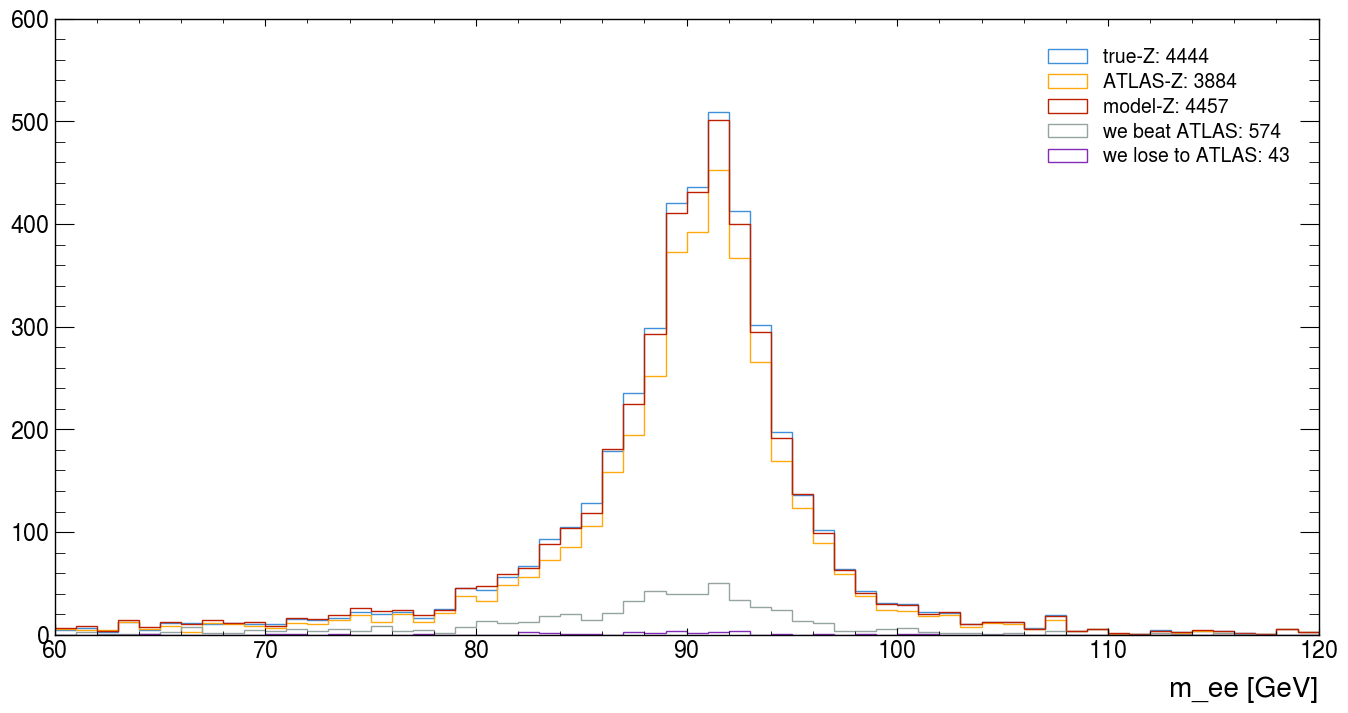

In [21]:
mask_we_win = (full_val_data['ATLAS_label'] == 0) & (model_prediction == 1) & (full_val_label == 1)
mask_we_lose = (full_val_data['ATLAS_label'] == 1) & (model_prediction == 0) & (full_val_label == 1)

fig, ax = plt.subplots(figsize=(16, 8))
counts_truth = ax.hist(full_val_data['m_ee'][full_val_label==1], bins=200, range=(0, 200), histtype='step', label=f"true-Z: {len(full_val_data['m_ee'][full_val_label==1])}")
# ax.hist(small_sample['m_ee'][truth_data==0], bins=200, range=(0, 200), histtype='step', label='non-Z')
counts_atlas = ax.hist(full_val_data['m_ee'][full_val_data['ATLAS_label']==1], bins=200, range=(0, 200), histtype='step', label=f"ATLAS-Z: {len(full_val_data['m_ee'][full_val_data['ATLAS_label']==1])}")
counts_model = ax.hist(full_val_data['m_ee'][model_prediction==1], bins=200, range=(0, 200), histtype='step', label=f"model-Z: {len(full_val_data['m_ee'][model_prediction==1])}")
counts_we_win = ax.hist(full_val_data['m_ee'][mask_we_win], bins=200, range=(0, 200), histtype='step', label=f"we beat ATLAS: {len(full_val_data['m_ee'][mask_we_win])}")
counts_we_lose = ax.hist(full_val_data['m_ee'][mask_we_lose], bins=200, range=(0, 200), histtype='step', label=f"we lose to ATLAS: {len(full_val_data['m_ee'][mask_we_lose])}")
# ax.hist(small_sample['m_ee'], bins=200, range=(0, 200), histtype='step', label='all events')
ax.set_xlabel('m_ee [GeV]')
ax.legend()
ax.set_xlim(60, 120)
# ax.set_yscale('log')
print('no')

no


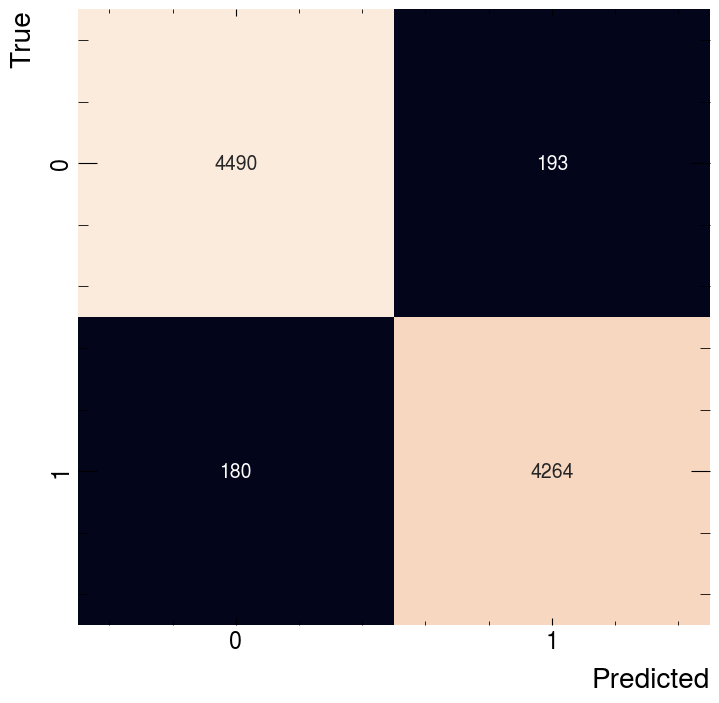

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(full_val_label, model_prediction)
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cbar = False)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
print('no')

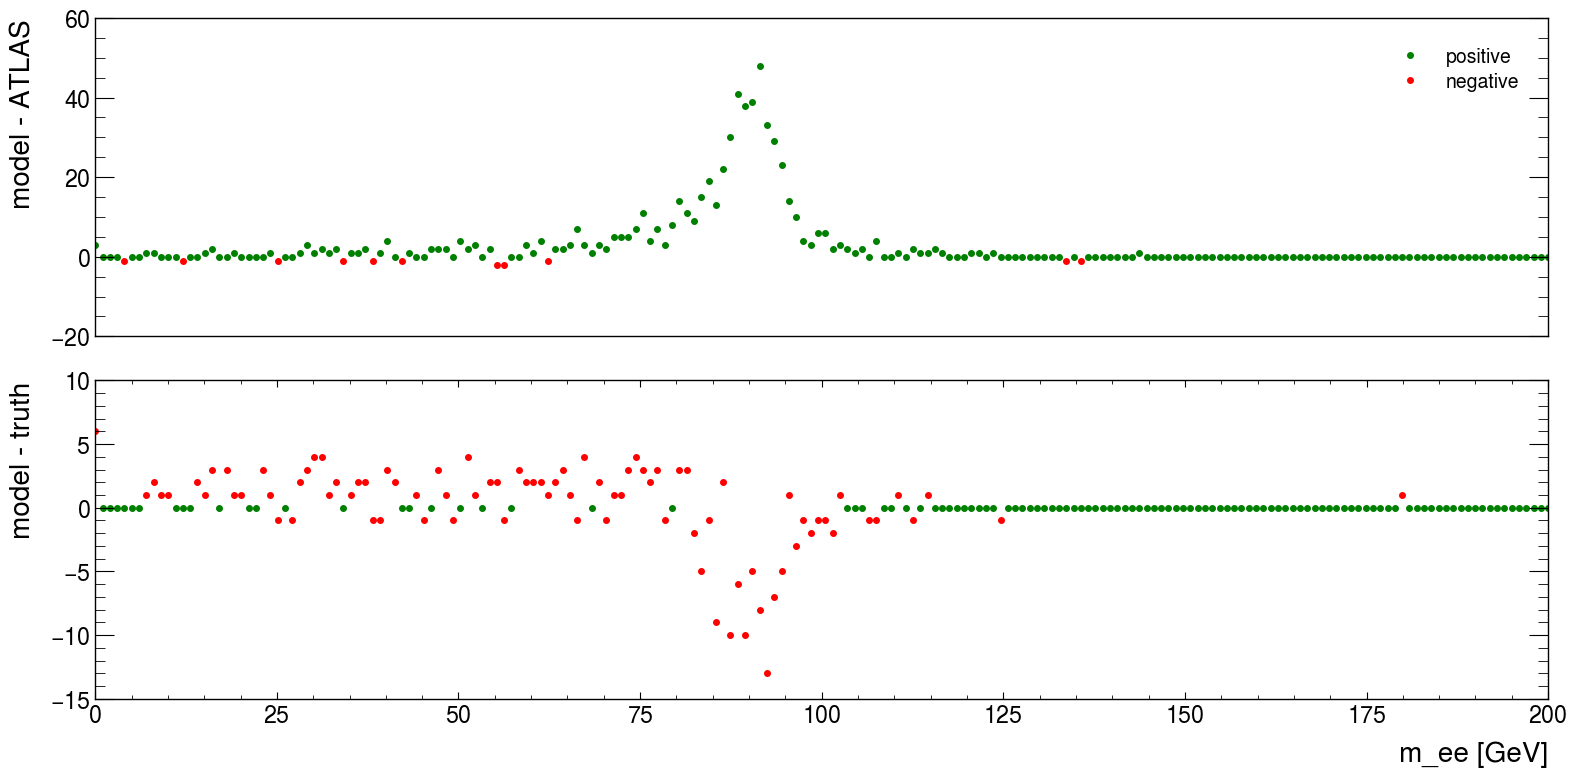

In [23]:
difference_modelvsatlas = counts_model[0] - counts_atlas[0]
difference_modelvtruth = counts_model[0] - counts_truth[0]
fig, ax = plt.subplots(2,1,figsize=(16, 8))
ax[0].plot(np.linspace(0,200,200)[difference_modelvsatlas>=0],difference_modelvsatlas[difference_modelvsatlas>=0],'.',color='g', label='positive')
ax[0].plot(np.linspace(0,200,200)[difference_modelvsatlas<0],difference_modelvsatlas[difference_modelvsatlas<0],'.',color='r' , label='negative')

ax[1].plot(np.linspace(0,200,200)[difference_modelvtruth==0],difference_modelvtruth[difference_modelvtruth==0],'.', color='g', label='identical')
ax[1].plot(np.linspace(0,200,200)[difference_modelvtruth!=0],difference_modelvtruth[difference_modelvtruth!=0],'.', color='r', label='wrong')
ax[1].set_xlabel('m_ee [GeV]')
ax[0].set_ylabel('model - ATLAS')
ax[1].set_ylabel('model - truth')
ax[0].legend()
ax[0].set_xticks([])

fig.tight_layout()